In [50]:
from lib.solver_tools.solver_client import SolverClient
from lib.solver_tools import Task
from lib.solver_tools.utils import make_task_comparison_link
import json
from copy import deepcopy
from lib.common_tools.read_token import read_solver_apikey
import os
import time

In [53]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import vrp_algorithms_lib.common_tools.file_utils as file_utils
import vrp_algorithms_lib.analytical_tools.viz as viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
my_apikey = read_solver_apikey()
solver_client = SolverClient(my_apikey)

In [30]:
# request_path = '../test_data/inputs/medium_test_1/request.json'
# task_id = '34000a30-948d94b2-8665fb47-a7eb3b85'

# request_path = '../test_data/inputs/large_test_1/request.json'
# task_id = '88060738-3eb5db87-9f6a7288-6fd4c3d2'

request_path = '../test_data/inputs/large_test_2/request.json'
task_id = 'f392f33d-1bab419a-24f43d12-acf0c715'

In [31]:
initial_request = solver_client.get_request(task_id)

In [46]:
def transform_request(initial_request, ):
    assert len(initial_request['depots']) == 1
    
    locations = [
        {
            'id': f'location {i+1}', 
            'depot_id': 'depot 1', 
            'point': l['point'], 
            'time_window': '00:00:00-1.00:00:00'
        } for i, l in enumerate(initial_request['locations'])  # time_windows are not supported yet!
    ]
    
    vehicles = [
        {
            'id': f'courier {i+1}', 
            'return_to_depot': False,
            'cost': {
                'fixed': 0,
                'hour': 0,
                'km': 8
            },
            'shifts': [
                {
                    'id': 'shift 1',
                    'time_window': '00:00:00-1.00:00:00'
                }
            ]
        } for i, v in enumerate(initial_request['vehicles'])
    ]
    
    depots = [
        {
            'id': f'depot {i+1}', 
            'point': d['point'], 
            'time_window': '00:00:00-1.00:00:00'
        } for i, d in enumerate(initial_request['depots'])
    ]
    
    options = {
        'time_zone': 3,
        'matrix_router': 'geodesic',
        'thread_count': 1,
        'task_count': 1,
        'temperature': 10000,
        'solver_time_limit_s': 60
    }
    
    new_request = {
        'locations': locations,
        'vehicles': vehicles,
        'depots': depots,
        'options': options
    }
    
    return new_request

In [47]:
transformed_request = transform_request(initial_request)

In [48]:
file_utils.save_json(transformed_request, request_path)

In [51]:
new_task_id = solver_client.add_task_and_get_task_id(transformed_request)

/b2bgeo/environments/common_env/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'courier.yandex.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [59]:
Task(new_task_id).map()

Neither solver_api_key nor ya_courier_token provided to SolverClient. Using client in limited functionality mode


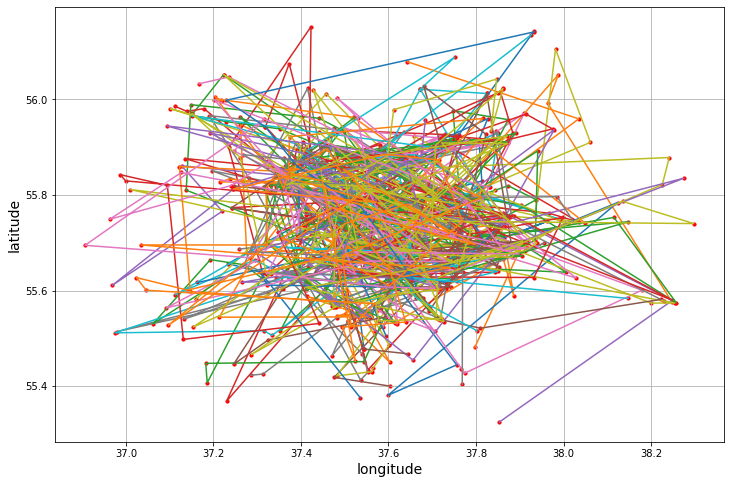

In [58]:
viz.plot_routes(transformed_request, file_utils.read_json('../test_data/results/annealing/large_test_2/1000000_iterations_routes.json')['routes'], legend=False)

In [63]:
import routeq_visualization.solver.analyze_vis_plt as analyze_vis_plt
import lib.solver_tools.analyze as analyze

In [66]:
analyze.costs_and_penalties_breakdown(result=solver_client.get_result(new_task_id))

metric
total_transit_distance_cost    13707.150292
Name: value, dtype: float64